In [7]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from hydra import initialize, compose
from lenstronomy.Plots import plot_util
from glob import glob

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import overplot, plot
from mejiro.lenses import lens_util

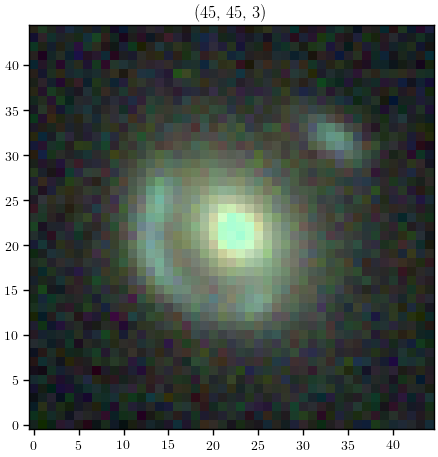

In [17]:
color_dir = config.machine.dir_05
pickle_dir = config.machine.dir_03
lens, rgb_model, rgb_image = lens_util.get_sample(pickle_dir, color_dir, 80)

plt.imshow(rgb_image)
plt.title(rgb_image.shape)
plt.show()

In [18]:
num_pix = rgb_image.shape[0]
coords = lens_util.get_coords(num_pix)

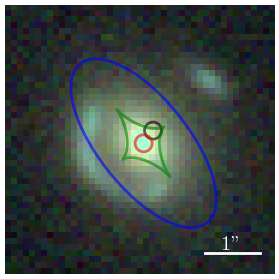

In [19]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.imshow(rgb_image, cmap='binary')

overplot.source_position(ax, lens, coords, linewidth=2, alpha=0.6, color='black')
overplot.lens_position(ax, lens, coords, linewidth=2, alpha=0.6, color='red')
overplot.caustics(ax, lens, coords, num_pix, delta_pix=0.11, linewidth=2, alpha=0.6, color='g')
overplot.critical_curves(ax, lens, coords, num_pix, delta_pix=0.11, linewidth=2, alpha=0.6, color='b')

plot_util.scale_bar(ax, d=rgb_image.shape[0], dist=1 / 0.11, text='1"', color='w', flipped=True)
# plot_util.coordinate_arrows(ax, d=lens.num_pix * .95, coords=lens.coords, color='w', font_size=15, arrow_size=0.02)

plt.axis(False)
# plt.legend(fontsize=12, bbox_to_anchor = (1.65, 0.5), loc='center right')

plt.savefig(os.path.join(figure_dir, 'roman_image.png'))
plt.show()

[critical lines are confusing, but this looks right](https://www.researchgate.net/figure/Three-basic-configurations-of-quad-lenses-cusp-top-fold-middle-and-cross-bottom_fig2_301817913)